done
tf.Tensor(
[[[[-1.12472393e-03]
   [-1.36261526e-03]
   [ 7.09181535e-04]
   [ 2.52407463e-03]
   [-3.67404171e-03]
   [ 5.26273157e-03]
   [-2.06681713e-03]
   [ 2.39110878e-03]
   [ 1.53565023e-03]
   [ 8.26407457e-04]
   [-6.02581678e-03]
   [ 1.49336189e-03]
   [ 3.32515221e-04]
   [-4.72295051e-03]
   [ 1.44964235e-03]
   [-8.02191161e-03]
   [-1.78901246e-04]
   [-5.32094855e-03]
   [-1.84179051e-03]
   [-3.35082901e-03]
   [-6.51367148e-03]
   [ 9.93903633e-03]
   [-5.23100933e-03]
   [-1.91347059e-02]
   [ 6.82885805e-03]
   [-3.83450114e-03]
   [-5.12192072e-03]
   [-1.95805146e-03]]

  [[ 5.19960793e-03]
   [-5.26429247e-03]
   [ 8.10099673e-03]
   [ 8.89965799e-03]
   [ 5.92533033e-03]
   [ 1.02053341e-02]
   [-3.21833533e-03]
   [ 8.90966225e-03]
   [ 8.61174613e-03]
   [-8.35286453e-03]
   [-2.45752907e-03]
   [ 1.49671203e-02]
   [ 1.56399552e-02]
   [-2.27495446e-03]
   [ 4.41960758e-03]
   [-4.16845363e-03]
   [ 1.73748471e-02]
   [ 2.25292556e-02]
   [ 7.78758666e

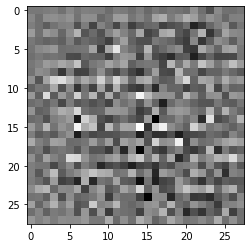

In [1]:
# coding: utf-8

import tensorflow as tf

# print(tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 加载数据集
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# 修改形状
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('f')
# 图片标准化 [-1, 1]
train_images = (train_images - 127.5) / 127.5

buffer_size = 60000
batch_size = 256
# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)


# 生成器
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)


print('done')
print(generated_image)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [2]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00049221]], shape=(1, 1), dtype=float32)


In [9]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint_ = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # save every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print('Time for epoch {} is {}s'.format(epoch+1, time.time()-start))
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

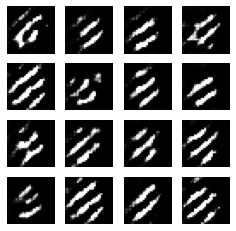

Time for epoch 5 is 340.183748960495s


In [ ]:
train(train_dataset, epochs)